In [2]:
from gw_signal_tools.inner_product import inner_product, norm, overlap
from gw_signal_tools.PSDs import psd_gw150914

import astropy.units as u
import lalsimulation.gwsignal.core.waveform as wfm

import matplotlib.pyplot as plt

# Inner Product Verifications

First we need example signals

In [3]:
# Define the dictionary
deltaT = 1./2048.*u.s
f_min = 20.*u.Hz  # Cutoff frequency
f_ref = 20.*u.Hz  # Frequency where we specify spins
distance = 440.*u.Mpc
inclination = 2.7*u.rad  # Value taken from posteriors.ipynb, where posterior of inclination is plotted
phiRef = 0.*u.rad
eccentricity = 0.*u.dimensionless_unscaled
longAscNodes = 0.*u.rad
meanPerAno = 0.*u.rad


parameters_gw150914 = {
    'mass1' : 36*u.solMass,
    'mass2' : 29*u.solMass,
    'deltaT' : deltaT,  # Needed even for FDWaveform, otherwise f_max very small
    # 'deltaF' : deltaT / u.s * u.Hz,  # Does work
    'f22_start' : f_min,
    'f22_ref': f_ref,
    'phi_ref' : phiRef,
    'distance' : distance,
    'inclination' : inclination,
    'eccentricity' : eccentricity,
    'longAscNodes' : longAscNodes,
    'meanPerAno' : meanPerAno,
    'condition' : 0
}

# Define the approximant
approximant = 'IMRPhenomXPHM'

# Call the generator
gen = wfm.LALCompactBinaryCoalescenceGenerator(approximant)


# Generate time domain waveform
hp_t, hc_t = wfm.GenerateTDWaveform(parameters_gw150914, gen)

# Two waveforms will be generated in frequency domain, first with finer
# sampling and then with coarser one
hp_f_fine, hc_f_fine = wfm.GenerateFDWaveform(parameters_gw150914, gen)

hp_f_coarse, hc_f_coarse = wfm.GenerateFDWaveform(parameters_gw150914 | {'deltaF': 1.0 / (hp_t.size * hp_t.dx)}, gen)

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/lalsimulation/gwsignal/core/waveform.py:226: UserWarning: This code is currently UNREVIEWED, use with caution!
  warnings.warn("This code is currently UNREVIEWED, use with caution!")


To show the difference in sampling, let us look at the values

In [4]:
print(hp_f_coarse.df, hp_f_fine.df)

0.5839749073282008 Hz 0.0625 Hz


This is almost one order of magnitude difference

In [5]:
# df_test = hp_f_coarse.df / 2  # Without 1/2 assertion error
# df_test = 0.125  # Testing of df parameter
# df_test = 0.125 * u.Hz  # Testing of df parameter -> results not even too bad
# df_test = 0.001  # Error for all three calls
# df_test = 2**-10  # Smaller number, but no error
df_test = None
# f_range_test = [f_min, 250]  # Activating makes results slightly more unequal
# f_range_test = [0, 250000]  # Testing of range parameter
f_range_test = None

print(norm(hp_t, psd_gw150914, df=df_test, f_range=f_range_test))
print(norm(hp_f_fine, psd_gw150914, df=df_test, f_range=f_range_test))
print(norm(hp_f_coarse, psd_gw150914, df=df_test, f_range=f_range_test))

29.753668752298207
29.75382206975821
29.632594300774073


In [6]:
print(overlap(hp_t, hp_f_coarse, psd_gw150914, optimize_time_and_phase=False))
print(overlap(hp_t, hp_f_fine, psd_gw150914, optimize_time_and_phase=False))
# No need for optimization here, signals need not be shifted

0.9996908777883473
0.9999994141119251


As we can see, sampling of input makes a notable difference because the quality of interpolation depends on that.

Nonetheless, all results are consistent and even the ones for coarser sampling are acceptable with the overlap being greater than $0.999$.


Now we look at the implementation utilizing ifft

In [7]:
overlap_series_coarse, overlap_coarse, peak_time_coarse = overlap(hp_t, hp_f_coarse, psd_gw150914, optimize_time_and_phase=True)
overlap_series_fine, overlap_fine, peak_time_fine = overlap(hp_t, hp_f_fine, psd_gw150914, optimize_time_and_phase=True)

print(overlap_coarse, overlap_fine)

0.9996896486104788 0.999999413930244


Larger than one of course makes no sense, but this only occurs in fourth digit
-> ah, does not occur if we do not use simpson norm in normalization constant; so using optimization for all computations in norm and overlap seems to make sense
-> results actually agree *really* well when doing optimization for all

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


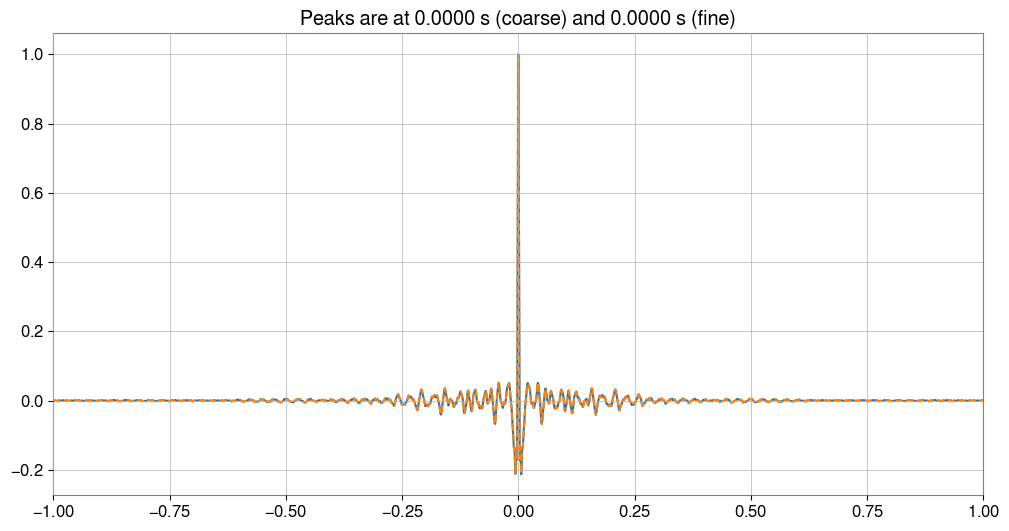

In [8]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(overlap_series_coarse)
ax.plot(overlap_series_fine, '--')

ax.set_title(f'Peaks are at {peak_time_coarse:.4f} (coarse) and {peak_time_fine:.4f} (fine)')

ax.set_xlim([-1, 1])

plt.show()

We can also demonstrate the influence of the PSD on inner product values and thus the SNR.

In [9]:
from gw_signal_tools.PSDs import psd_o3_h1, psd_o3_l1, psd_o3_v1, psd_sim

In [10]:
for psd in [psd_gw150914, psd_o3_h1, psd_o3_l1, psd_o3_v1, psd_sim]:
    print(f'SNR for {psd.name}: {norm(hp_f_fine, psd, f_range=[f_min, None])}')

SNR for PSD around GW150914: 29.75382206975821
SNR for Typical PSD of Hanford detector in O3: 48.48046394692113
SNR for Typical PSD of Livingston detector in O3: 56.54845445428428
SNR for Typical PSD of VIRGO detector in O3: 24.404945725530464
SNR for PSD values as simulated by `SimNoisePSDaLIGOZeroDetHighPower`: 82.61232474405267


## Match Testing

In [11]:
from gw_signal_tools.inner_product import optimized_inner_product, pad_to_get_target_df, td_to_fd_waveform, fd_to_td_waveform

import numpy as np
import matplotlib.pyplot as plt

In [12]:
# Reference value
ref_val = inner_product(hp_t, hp_t, psd_gw150914)

In [13]:
# inner_product(hp_t, hp_f_fine, psd_gw150914, optimize_time_and_phase=True)

In [14]:
test1, test2, _ = inner_product(hp_t, hp_f_fine, psd_gw150914, optimize_time_and_phase=True)

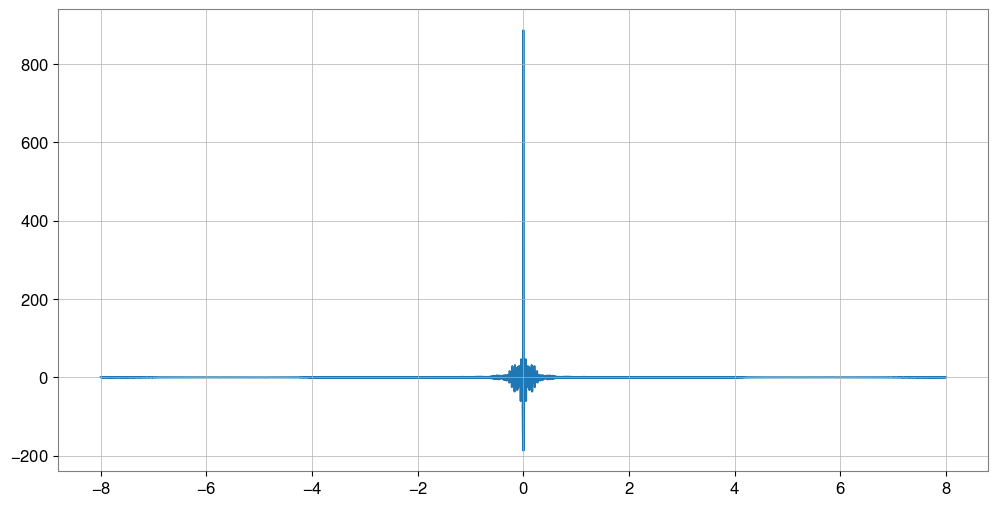

In [15]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(test1)
ax.plot(test2, '--')

# ax.set_xlim([10, 42])

plt.show()

Equal, good. As expected, conversion in inner_product works, so we can focus on what optimized_inner_product does

Note: this code was used when end of inner_product looked like this:
```
if optimize_time_and_phase:
    # Shit, problem: we cut f_range... But need start at zero for ifft -> maybe do in optimized_inner_product function?

    number_to_append = int((float(f_lower / f_lower.unit) - 0.0) / df_float)  # Symbolic -0.0 to make it clear what happens
    
    f_series_to_pad = FrequencySeries(
        np.zeros(number_to_append),
        unit=u.dimensionless_unscaled,
        f0=0.0,
        df=df,
        dtype=complex
    )

    signal1 = f_series_to_pad.append(signal1, inplace=False)
    signal2 = f_series_to_pad.append(signal2, inplace=False)

    # psd = f_series_to_pad.fill(1.0).append(psd, inplace=False)  # Otherwise division by zero. Contribution is zero anyway because signals are zero there
    f_series_to_pad.fill(1.0)  # No return here, thus has to be done separately
    psd = f_series_to_pad.append(psd, inplace=False)  # Otherwise division by zero. Contribution is zero anyway because signals are zero there

    # return optimized_inner_product(signal1, signal2, psd)
    return signal1, signal2, psd
    # TODO: decide if we divide by norm here? Or in overlap? Maybe do in
    # separate match function that always sets optimize_time_and_phase=True?
else:
    return inner_product_computation(signal1, signal2, psd)
```

In [16]:
match_series, match_val, peak_time = inner_product(hp_t, hp_f_fine, psd_gw150914, optimize_time_and_phase=True)
# match_series, match_val = optimized_inner_product(*inner_product(hp_t, hp_t, psd_gw150914, optimize_time_and_phase=True))

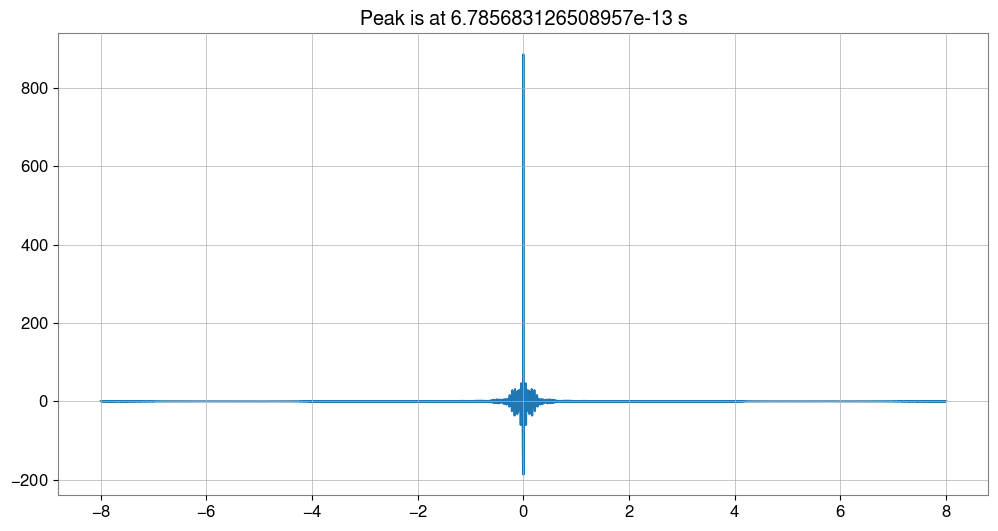

In [17]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(match_series)

ax.set_title(f'Peak is at {peak_time}')

plt.show()

In [18]:
hp_t_shifted = hp_t.copy()
hp_t_shifted.times += 2.0 * u.s
# hp_t_shifted.times += 10.0 * u.s
# hp_t_shifted.times += 100.0 * u.s

# hp_t_shifted.times += pad_to_get_target_df(hp_t, df=0.0625).duration
# hp_t_shifted.times += 0.96 * pad_to_get_target_df(hp_t, df=0.0625).duration
# hp_t_shifted.times += 1.1 * pad_to_get_target_df(hp_t, df=0.0625).duration
# hp_t_shifted.times += 0.5 * pad_to_get_target_df(hp_t, df=0.0625).duration  # This one is fun

# hp_t_shifted.times += hp_t.duration
# hp_t_shifted.times += 0.96 * hp_t.duration
# hp_t_shifted.times += 1.1 * hp_t.duration
# hp_t_shifted.times += 1.5 * hp_t.duration

match_series_v2, match_val_v2, peak_time_2 = inner_product(hp_t, hp_t_shifted, psd_gw150914, df=2**-8, optimize_time_and_phase=True)

Ohhh, it makes perfect sense that this overlap of frequency domain waveform and shifted time waveform is not the same. These two have different starting times!!! Therefore, the frequency domain waveforms are not equal and their overlap is not equal to their individual norm (the norms, on the other hand, are expected to be equal because the phase factors cancel)

Explanation why things get more equal as shift is increased: the oscillation in frequency domain has increased frequency (which is t0), so the sampled values have higher chance of actually coinciding with the envelope, i.e. the signal in frequency domain. This corresponds to an increasing overlap

In [19]:
print(hp_t.t0, hp_t_shifted.t0, hp_t_shifted.t0 - hp_t.t0)  # Confirmation everything has worked out

-1.615234375 s 0.384765625 s 2.0 s


In [20]:
print(ref_val, inner_product(hp_t_shifted, hp_t_shifted, psd_gw150914), match_val, match_val_v2)

885.2808042214867 885.2808042214867 885.4726554600578 880.6177012350646


First two should be perfectly equal. Last two should be very close

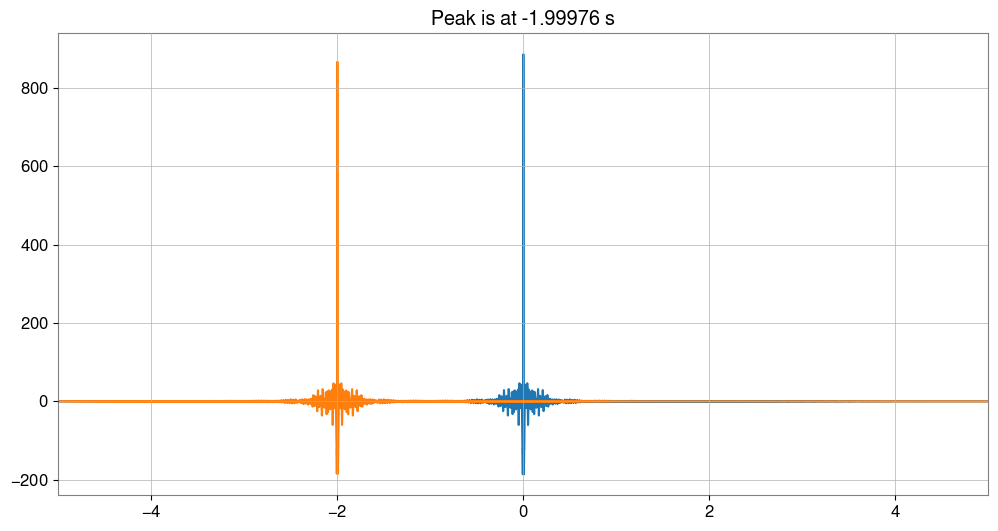

In [21]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(match_series)
ax.plot(match_series_v2)

ax.set_title(f'Peak is at {peak_time_2:.5f}')

ax.set_xlim([-5, 5])
# ax.set_xlim([-2.5, -1.5])

plt.show()

Ok, nice. Peak at correct shift (see explanation below if it looks wrong at first sight).

Interesting, around the peak it looks like a sinc


Hmmm now it becomes more interesting: values are relatively equal, but they differ by factor of 2 from correct result... Is this due to different conventions with integration region?

In [22]:
print(np.sqrt(ref_val), norm(hp_t_shifted, psd_gw150914), np.sqrt(match_val), np.sqrt(match_val_v2))

29.753668752298207 29.753668752298207 29.756892570630722 29.675203474198195


Same as above, first two should be equal and last two should be close

Explanation of second peak (or single peak if only one is there):

In [23]:
print(pad_to_get_target_df(hp_t, df=hp_f_fine.df).duration, pad_to_get_target_df(hp_t_shifted, df=hp_f_fine.df).duration)
print(pad_to_get_target_df(hp_t, df=hp_f_fine.df).times[-1] - pad_to_get_target_df(hp_t_shifted, df=hp_f_fine.df).times[-1])

16.0 s 16.0 s
-2.0 s


Total length is 16s, so 14s is exactly the shift of 2s away from that. Probably has to do with the cyclic wrap-around that happens when going from FD to TD (for frequency components, shift of 2 or -2 makes no big difference).

### Tests with match of two signals

In [24]:
hp_1, _ = wfm.GenerateFDWaveform(parameters_gw150914 | {'mass1': 10 * u.solMass, 'mass2': 10 * u.solMass}, gen)
hp_2, _ = wfm.GenerateFDWaveform(parameters_gw150914 | {'mass1': 20 * u.solMass, 'mass2': 20 * u.solMass}, gen)

In [25]:
df = 2**-8

# (inner_product(hp_1, hp_2, psd_gw150914, df=df, optimize_time_and_phase=True)[1]
# / norm(hp_1, psd_gw150914, df=df)
# / norm(hp_2, psd_gw150914, df=df)
# )
overlap(hp_1, hp_2, psd_gw150914, df=df, optimize_time_and_phase=True)[1]

<Quantity 0.196141>

## PyCBC Comparisons

In [26]:
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower

from gwpy.timeseries.timeseries import TimeSeries
from gwpy.frequencyseries.frequencyseries import FrequencySeries

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [27]:
f_low, f_high = 20, 350

sample_rate = 4096


# Enter some arbitrary parameters here
signals_to_compare = {
    'signal1': {
        'mass1': 10,
        'mass2': 10,
        'spin1': 0.6,
        'spin2': 0.0
    },
    'signal2':{
        'mass1': 96,
        'mass2': 20,
        'spin1': 0.0,
        'spin2': 0.1
    }
}


hp_1_pycbc, _ = get_fd_waveform(
    approximant=approximant,
    **signals_to_compare['signal1'],
    f_lower=f_low,
    f_upper=f_high,
    delta_f=1.0/sample_rate
)

hp_2_pycbc, _ = get_fd_waveform(
    approximant=approximant,
    **signals_to_compare['signal2'],
    f_lower=f_low,
    f_upper=f_high,
    delta_f=1.0/sample_rate
)

tlen = max(len(hp_1_pycbc), len(hp_2_pycbc))
hp_1_pycbc.resize(tlen)
hp_2_pycbc.resize(tlen)

delta_f = 1.0 / hp_2_pycbc.duration
flen = tlen//2 + 1
psd_pycbc = aLIGOZeroDetHighPower(flen, delta_f, f_low)


hp_1_pycbc_converted = FrequencySeries.from_pycbc(hp_1_pycbc)
hp_2_pycbc_converted = FrequencySeries.from_pycbc(hp_2_pycbc)
psd_pycbc_converted = FrequencySeries.from_pycbc(psd_pycbc)

In [28]:
overlap_normalized_pycbc, i = match(hp_1_pycbc, hp_2_pycbc, psd=psd_pycbc, low_frequency_cutoff=f_low, high_frequency_cutoff=f_high)

print(f'The overlap is: {overlap_normalized_pycbc:.5f}')

The overlap is: 0.12560


In [29]:
overlap_series_normalized, overlap_normalized, peak_time = overlap(hp_1_pycbc_converted, hp_2_pycbc_converted, psd_pycbc_converted, f_range=[f_low, f_high], optimize_time_and_phase=True)

print(f'The overlap is: {overlap_normalized:.5f}')

The overlap is: 0.12536


In [30]:
print(f'The relative error is {(overlap_normalized_pycbc - overlap_normalized) / overlap_normalized_pycbc}')

The relative error is 0.0018849974600915237


/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


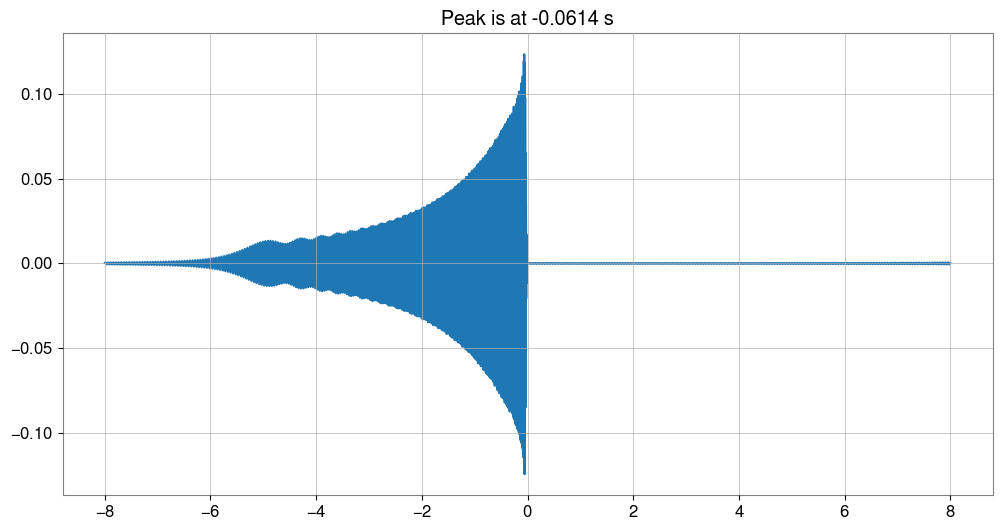

In [31]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(overlap_series_normalized)

ax.set_title(f'Peak is at {peak_time:.4f}')

plt.show()

### Other Sanity Checks

Agreement with PyCBC verified, now some other sanity checks (overlap with itself should be one, similar for shifted signal).

In [32]:
norm_series_1, norm_1, peak_time_1 = overlap(hp_1_pycbc_converted, hp_1_pycbc_converted, psd_pycbc_converted, f_range=[f_low, f_high], optimize_time_and_phase=True)
norm_series_2, norm_2, peak_time_2 = overlap(hp_2_pycbc_converted, hp_2_pycbc_converted, psd_pycbc_converted, f_range=[f_low, f_high], optimize_time_and_phase=True)

In [33]:
print(norm_1, norm_2)

0.9999999999999999 1.0000000000000002


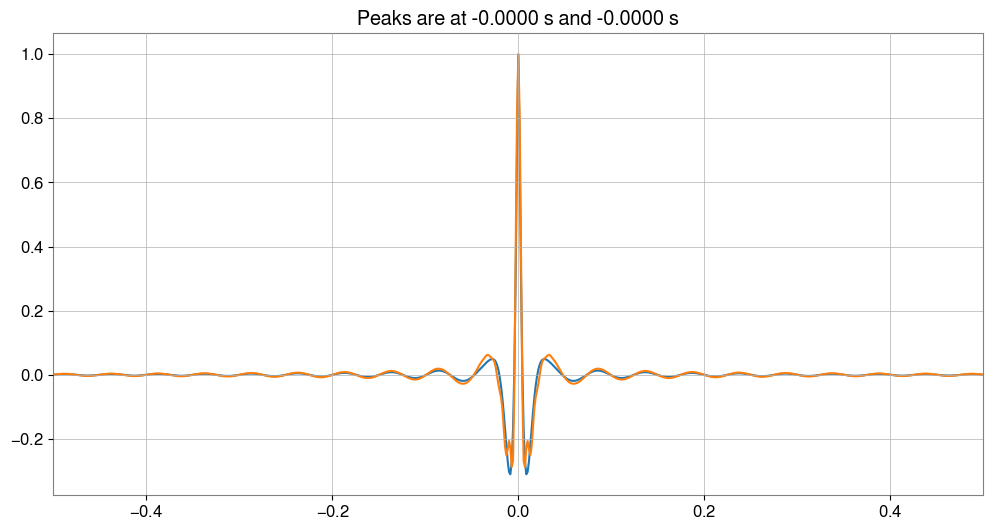

In [34]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(norm_series_1)
ax.plot(norm_series_2)

ax.set_title(f'Peaks are at {peak_time_1:.4f} and {peak_time_2:.4f}')

ax.set_xlim([-0.5, 0.5])  # Zoom onto relevant interval

plt.show()

In [35]:
hp_1_pycbc_converted_shifted = hp_1_pycbc_converted.copy()

t_shift = 2.0 * u.s

hp_1_pycbc_converted_shifted *= np.exp(1.j * 2 * np.pi * hp_1_pycbc_converted_shifted.frequencies * t_shift)

In [36]:
overlap_series_normalized, overlap_normalized, peak_time = overlap(hp_1_pycbc_converted, hp_1_pycbc_converted_shifted, psd_pycbc_converted, f_range=[f_low, f_high], optimize_time_and_phase=True)

In [37]:
print(f'The overlap is {overlap_normalized:.5f}')
print(f'The relative error is {1.0 - overlap_normalized:.5f}')

The overlap is 0.99783
The relative error is 0.00217


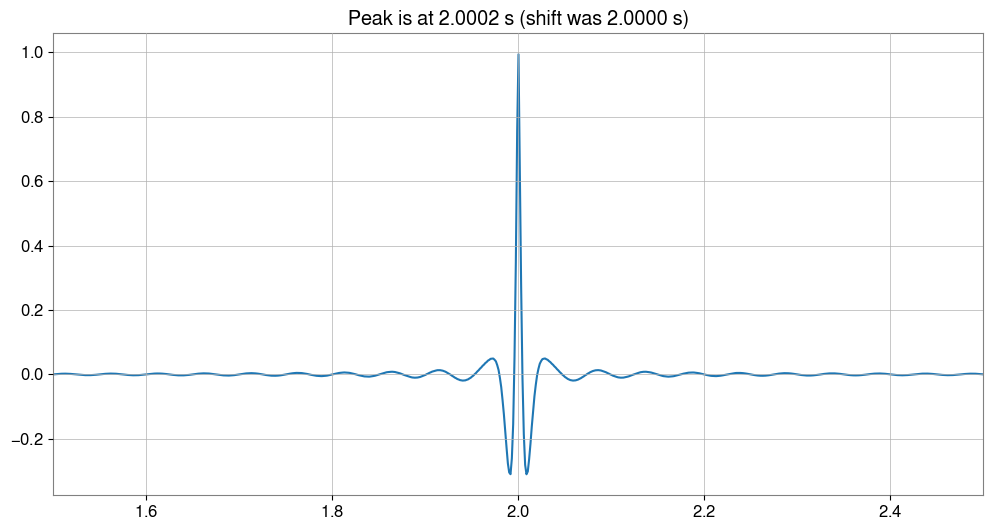

In [38]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(overlap_series_normalized)

ax.set_title(f'Peak is at {peak_time:.4f} (shift was {t_shift:.4f})')

ax.set_xlim([t_shift.value - 0.5, t_shift.value + 0.5])  # Zoom onto relevant interval

plt.show()

Question: could we have inferred a better time?

In [39]:
print(f'Difference is t_peak - t_shift = {peak_time - t_shift:.5f}, while resolution is {overlap_series_normalized.dt:.5f}')

Difference is t_peak - t_shift = 0.00018 s, while resolution is 0.00143 s


Answer: no. The difference between inferred and actual shift value are smaller than the resolution, i.e. cannot be resolved for this sample size.

## Proof that function does not change input

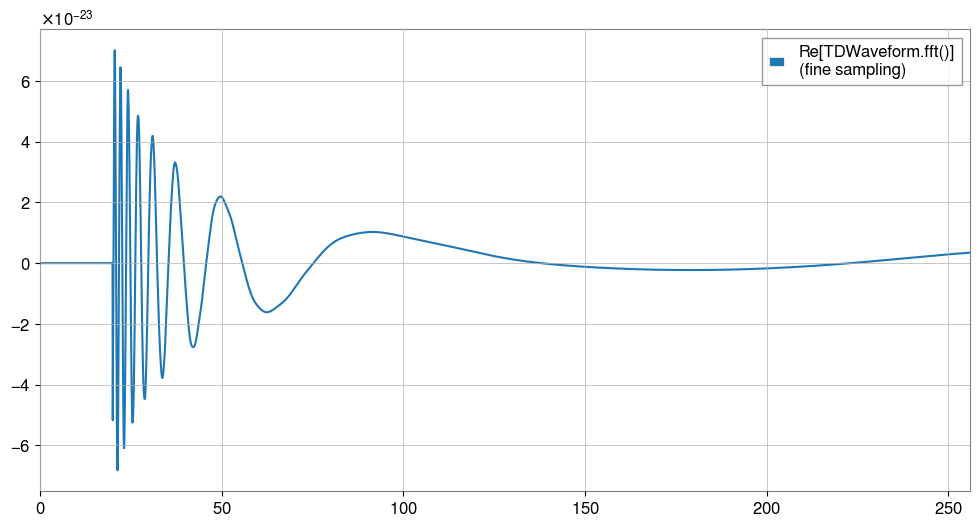

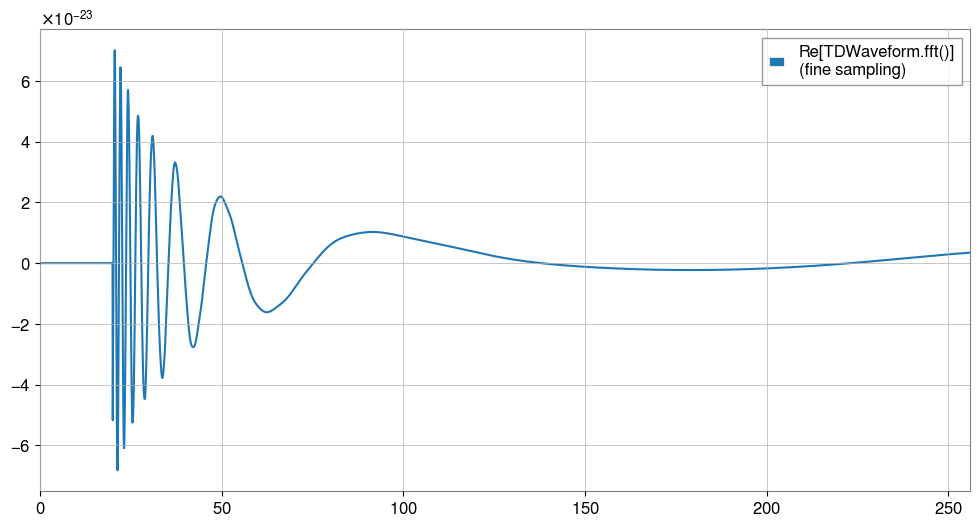

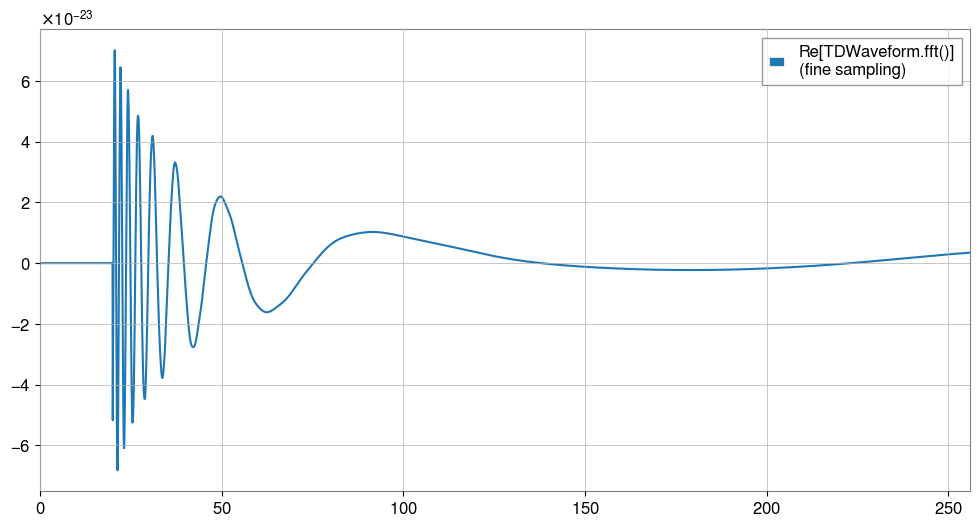

In [40]:
hp_f_fine, hc_f_fine = wfm.GenerateFDWaveform(parameters_gw150914, gen)



f,ax = plt.subplots(figsize=(12, 6))

ax.plot(np.real(hp_f_fine), label='Re[TDWaveform.fft()]\n(fine sampling)')

ax.legend()

# ax.set_xlim([0.0, 42])
ax.set_xlim([0.0, 256])

plt.show()


norm(hp_f_fine, psd_gw150914, df=hp_f_fine.df, f_range=[50, 100], optimize_time_and_phase=True)


f,ax = plt.subplots(figsize=(12, 6))

ax.plot(np.real(hp_f_fine), label='Re[TDWaveform.fft()]\n(fine sampling)')

ax.legend()

# ax.set_xlim([0.0, 42])
ax.set_xlim([0.0, 256])

plt.show()


norm(hp_f_fine, psd_gw150914, df=0.01, f_range=[50, 100], optimize_time_and_phase=True)


f,ax = plt.subplots(figsize=(12, 6))

ax.plot(np.real(hp_f_fine), label='Re[TDWaveform.fft()]\n(fine sampling)')

ax.legend()

# ax.set_xlim([0.0, 42])
ax.set_xlim([0.0, 256])

plt.show()

## Benchmarking

Testing which method is most efficient

In [40]:
# Set test parameters
df_test = None
f_range_test = None

In [41]:
_ = match(hp_1_pycbc, hp_2_pycbc, psd=psd_pycbc, low_frequency_cutoff=f_low, high_frequency_cutoff=f_high)  # Initialize match function (not sure if it works)

%timeit match(hp_1_pycbc, hp_2_pycbc, psd=psd_pycbc, low_frequency_cutoff=f_low, high_frequency_cutoff=f_high)

2.01 s ± 81.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Hm, this can't be right. There is probably some initilization going on for each call

In [42]:
%timeit -n 100 -r 10 norm(hp_t, psd_gw150914, df=df_test, f_range=f_range_test, optimize_time_and_phase=True)

13.9 ms ± 1.13 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [43]:
%timeit -n 100 -r 10 norm(hp_t, psd_gw150914, df=0.125, f_range=f_range_test, optimize_time_and_phase=True)

9.46 ms ± 907 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [44]:
%timeit -n 100 -r 10 norm(hp_f_fine, psd_gw150914, df=df_test, f_range=f_range_test, optimize_time_and_phase=True)

7.43 ms ± 67.3 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [45]:
%timeit -n 100 -r 10 norm(hp_f_coarse, psd_gw150914, df=df_test, f_range=f_range_test, optimize_time_and_phase=True)

8.49 ms ± 305 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


Clearly, choice of df makes bigger difference for time domain waveform, as opposed to frequency domain one. -> I think this changed; for df=None there is no need for resampling, which is because of correct input df

However, one should remember that generating with finer resolution also takes more time. So let us now see which method is fastest overall

In [46]:
print(gen.metadata['implemented_domain'], gen.metadata['generation_domain'])

freq freq


Thus, in theory, frequency domain should be much faster (since model is implemented there and inner product computation is also faster there)

In [47]:
%%timeit -n 10 -r 10

hp_t, _ = wfm.GenerateTDWaveform(parameters_gw150914, gen)

norm(hp_t, psd_gw150914, df=df_test, f_range=f_range_test)

188 ms ± 10.8 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [48]:
%%timeit -n 10 -r 10

hp_t, _ = wfm.GenerateTDWaveform(parameters_gw150914, gen)

norm(hp_t, psd_gw150914, df=0.125, f_range=f_range_test)

196 ms ± 12.4 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [49]:
%%timeit -n 10 -r 10

hp_f_fine, _ = wfm.GenerateFDWaveform(parameters_gw150914, gen)

norm(hp_f_fine, psd_gw150914, df=df_test, f_range=f_range_test)

201 ms ± 11.1 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [50]:
%%timeit -n 10 -r 10

hp_f_coarse, _ = wfm.GenerateFDWaveform(parameters_gw150914 | {'deltaF': 1.0 / (hp_t.size * hp_t.dx)}, gen)

norm(hp_f_coarse, psd_gw150914, df=df_test, f_range=f_range_test)

197 ms ± 7.55 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


The speeds are very similar for all of them. Naturally, finer sampling takes longer compared to coarser one, but apart from that the differences are almost non-existent